# Colab env settings

In [ ]:
!git clone https://github.com/bochendong/car_racing.git

Cloning into 'car_racing'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 66 (delta 34), reused 18 (delta 7), pack-reused 0
Unpacking objects: 100% (66/66), done.


In [ ]:
%%capture
!sudo apt update && sudo apt install python-opengl
!sudo apt update && sudo apt install xvfb
!pip install gym-notebook-wrapper stable-baselines[mpi] box2d box2d-kengz pyvirtualdisplay pyglet
!pip install wandb
!pip install pyvirtualdisplay -qq
!pip install folium==0.2.1
!apt-get install -y xvfb python-opengl ffmpeg -qq

In [ ]:
!pip install box2d

In [ ]:
import numpy as np
import random

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

from torch.autograd import Function

import gnwrapper
import gym
from gym import logger as gymlogger
gymlogger.set_level(30)

from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import wandb

%matplotlib inline
import matplotlib.pyplot as plt
import os
import glob

In [ ]:
%cd car_racing

In [ ]:
import car_racing as cr

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print(device)

if (os.path.exists("./output_r")) == False:
    os.mkdir("output_r")
    
for epoch in range (3000):
    files = glob.glob("./output_r/*.png")

    for f in files:
        os.remove(f)

# Car_racing Enviorment settings

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
env_green = gnwrapper.Animation(cr.CarRacing())
env_green = cr.CarRacing(color = 'g')
obs = env_green.reset()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
def get_random(state):
    red_scale, green_scale, blue_scale = 1., 1., 1.
    base_scale = 0.5
    while (red_scale == green_scale == blue_scale):
        add_green = random.randint(0, 1)
        add_red = random.randint(0, 1)
        add_blue = random.randint(0, 1)
        if (add_red): 
            red_scale = random.uniform(0.5, 1.1)
        if (add_green): 
            green_scale = random.uniform(0.5, 1.1)
        if (add_blue): 
            blue_scale = random.uniform(0.5, 1.1)
            
    for i in range (0, 4):
        s = torch.transpose(state[i], 0, 2)
        road = s [1] - s [0] * 0.6 - s[2] * 0.4
        road = torch.stack((road, road, road), 0)
        ones = torch.ones(3, 96, 96).to(device)

        road_mask = torch.logical_xor(road, ones)
        road_layer = s * road_mask

        light_green = 204 / 128. - 1
        light_green_mask = torch.logical_xor(s - light_green , ones)
        light_green_layer = s * light_green_mask

        dark_green = 230 / 128. - 1
        dark_green_mask = torch.logical_xor(s - dark_green , ones)
        dark_green_layer = s * dark_green_mask

        bg_layer = light_green_layer + dark_green_layer

        ones = torch.ones(96, 96).to(device)
        back_ground_mask = torch.logical_xor(bg_layer[1], ones)

        red_channel = (back_ground_mask * 128) /128. - 1
        green_channel = (back_ground_mask * 128) /128. - 1
        blue_channel = (back_ground_mask * 128) /128. - 1

        if (add_red): red_channel = bg_layer[1] * red_scale
        if (add_green): green_channel = bg_layer[1] * green_scale
        if (add_blue): blue_channel = bg_layer[1] * blue_scale

        new_bg_layer = torch.stack((red_channel, green_channel, blue_channel), 0)

        new_state = new_bg_layer + road_layer

        state[i] = torch.transpose(new_state, 0, 2)
        
    return state  

def get_random_buffer(buffer, batch_size):
    target_buffer = buffer.clone()
    for i in range (batch_size):
        target_buffer[i] = get_random(target_buffer[i])
    return target_buffer    

In [ ]:
class Env():
    def __init__(self, color, seed = 0):
        self.env = gnwrapper.Animation(cr.CarRacing(color = color))
        self.env = cr.CarRacing(color = color)
        self.color = color
        self.env.seed(seed)
        self.reward_threshold = 1000

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb = self.env.reset()
        img_rgb = img_rgb / 128. - 1
        self.stack = [img_rgb] * 4
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(8):
            img_rgb, reward, die, _ = self.env.step(action)

            if die: reward += 100

            if self.color == 'g' and np.mean(img_rgb[:, :, 1]) > 185.0:
                  reward -= 0.05

            total_reward += reward

            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break

        img_rgb = img_rgb / 128. - 1
        self.stack.pop(0)
        self.stack.append(img_rgb)
        assert len(self.stack) == 4
        return np.array(self.stack), total_reward, done, die

    def step_eval(self, action):
        img_rgb, reward, done, _ = self.env.step(action)

        img_rgb = img_rgb / 128. - 1
        self.stack.pop(0)
        self.stack.append(img_rgb)
        return np.array(self.stack), reward, done, _

    def render(self, *arg):
        self.env.render(*arg)

    @staticmethod
    def reward_memory():
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

In [ ]:
class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None  

class DANN(nn.Module):
    def __init__(self, num_out = 2):
        super(DANN, self).__init__()
        self.sketch = nn.Sequential(
            nn.Conv3d(4, 4, kernel_size=(1, 1, 3), stride=1),
            nn.ReLU(),
        )
        self.feature = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(4, 8, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),
        )

        self.cnn_base = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),
        )

        self.domain_classifier = nn.Sequential(
            # 1600, 512
            nn.Linear(64 * 5 * 5, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 2),
        )

        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)
      
    def forward(self, input, a = 0.1):
        sketch = self.sketch(input)
        sketch = torch.squeeze(sketch)

        feature = self.feature(sketch)

        out = self.cnn_base(feature)
        out = out.view(-1, 256)
        v = self.v(out)
        out = self.fc(out)

        alpha = self.alpha_head(out) + 1
        beta = self.beta_head(out) + 1

        feature = feature.view(-1, 64 * 5 * 5)
        reverse_feature = ReverseLayerF.apply(feature, a)
        domain_output = self.domain_classifier(reverse_feature)

        return (alpha, beta), v, domain_output, sketch

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

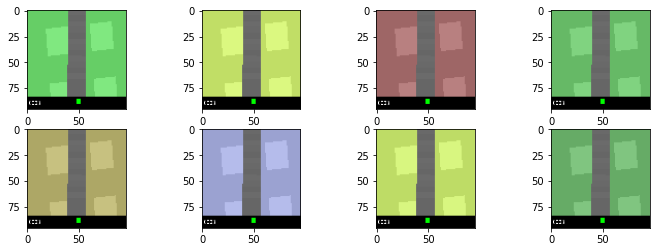

In [ ]:
class Agent():
    max_grad_norm = 0.5
    clip_param = 0.1
    ppo_epoch = 10

    transition = np.dtype([('s', np.float64, (4, 96, 96, 3)), ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (4, 96, 96, 3))])
    def __init__(self, net, criterion, optimizer, buffer_capacity = 2000, batch_size = 128):
        self.net = net
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.criterion = criterion
        self.optimizer = optimizer

        self.source_buffer = np.empty(self.buffer_capacity, dtype=self.transition)
        self.counter = 0

    def select_action(self, state):
        state = torch.from_numpy(state).double().to(device).unsqueeze(0)
        with torch.no_grad():
            out = self.net.sketch(state)
            out = torch.squeeze(out)
            out = self.net.feature(out)

            out = self.net.cnn_base(out)
            out = out.view(-1, 256)
            out = self.net.fc(out)
            alpha = self.net.alpha_head(out) + 1
            beta = self.net.beta_head(out) + 1

        dist = Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).sum(dim=1)

        action = action.squeeze().cpu().numpy()
        a_logp = a_logp.item()
        return action, a_logp

    def store(self, transition):
        self.source_buffer[self.counter] = transition
        self.counter += 1
        if self.counter == self.buffer_capacity:
            self.counter = 0
            return True

        return False

    def update(self, epoch, eta = 0.1):
        s = torch.tensor(self.source_buffer['s'], dtype=torch.double).to(device)
        a = torch.tensor(self.source_buffer['a'], dtype=torch.double).to(device)
        r = torch.tensor(self.source_buffer['r'], dtype=torch.double).to(device).view(-1, 1)
        s_ = torch.tensor(self.source_buffer['s_'], dtype=torch.double).to(device)
        old_a_logp = torch.tensor(self.source_buffer['a_logp'], dtype=torch.double).to(device).view(-1, 1)

        source_domain_label = torch.zeros(self.batch_size).long()
        target_domain_label = torch.ones(self.batch_size).long()
        source_domain_label = source_domain_label.to(device)
        target_domain_label = target_domain_label.to(device)

        with torch.no_grad():
            target_v = r + 0.99 * self.net(s_)[1]
            adv = target_v - self.net(s)[1]

        image_array = []
        source_acc_array = []
        target_acc_array = []
        for _ in range(self.ppo_epoch):
            total = 0
            source_domain_correct = 0
            tagret_domain_correct = 0
            add_image = True
            
            for index in BatchSampler(SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, True):
                total += self.batch_size
                loss = 0
                
                with torch.no_grad():
                    target_batch = get_random_buffer(s[index], self.batch_size)
                

                (alpha, beta), v, domain_out, s_sketch = self.net(s[index], eta)
                source_domain_loss = self.criterion(domain_out, source_domain_label)

                _, predicted = torch.max(domain_out.data, 1)
                source_domain_correct += predicted.eq(source_domain_label.data).cpu().sum().item()

                _, _,  domain_out, t_sketch = self.net(target_batch, eta)
                target_domain_loss = self.criterion(domain_out, target_domain_label)

                _, predicted = torch.max(domain_out.data, 1)
                tagret_domain_correct += predicted.eq(target_domain_label.data).cpu().sum().item()
                
                if (add_image):
                    image = s_sketch[0][0].reshape(96, 96)
                    image = image.cpu().detach().numpy()
                    image_array.append(image)
                
                    image = t_sketch[0][0].reshape(96, 96)
                    image = image.cpu().detach().numpy()
                    image_array.append(image)
                    
                    add_image = False

                dist = Beta(alpha, beta)
                a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True)
                ratio = torch.exp(a_logp - old_a_logp[index])
                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.smooth_l1_loss(self.net(s[index])[1], target_v[index])

                loss += action_loss + 2. * value_loss + source_domain_loss + target_domain_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            source_acc_array.append( source_domain_correct / total )
            target_acc_array.append( tagret_domain_correct / total )
        
        source_acc_mean = 0
        print("Source acc", end = ' ')
        for acc in source_acc_array:
            source_acc_mean += acc
            print("%.2f" % acc, end = ' ')
        print(" ")
        target_acc_mean = 0
        print("Target acc", end = ' ')
        for acc in target_acc_array:
            target_acc_mean += acc
            print("%.2f" % acc, end = ' ')
        print(" ")
            
        f, axs = plt.subplots(2, 10, figsize = (16, 4))
        axs = axs.flatten()
        for img, ax in zip(image_array, axs):
            ax.imshow(img)
        f.savefig('./output_r/%04d.png' % epoch)
        plt.close(f)
        
        return source_acc_mean / 10 , target_acc_mean / 10

In [ ]:
def eval(agent, env):
    score = 0
    state = env.reset()

    for t in range(1000):
        action, a_logp = agent.select_action(state)

        state_, reward, done, _ = env.step_eval(action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.]))

        score += reward

        state = state_

        if done:
            break

    return score

In [ ]:
def train(source_env, target_env, agent):
    training_records= []
    running_score_records = []
    running_score = 0
    
    c1_running_score = 0
    c1_training_records = []
    c1_running_score_records = []
    
    c2_running_score = 0
    c2_training_records = []
    c2_running_score_records = []
    
    eta = 0.2

    for i_ep in range(3000):
        score = 0
        state = source_env.reset()

        for t in range(1000):
            action, a_logp = agent.select_action(state)
            state_, reward, done, die = source_env.step(action * np.array([2., 1., 1.])\
                                                                       + np.array([-1., 0., 0.]))
            score += reward

            should_update = agent.store((state, action, a_logp, reward, state_))

            if should_update: 
                if (i_ep < 500): eta_max =  0.5
                elif (i_ep < 1500): eta_max = 0.45
                else: eta_max = 0.3
                    
                print("eta: %.2f" % eta)
                s_acc, t_acc = agent.update(epoch = i_ep, eta = eta)
                
                if (s_acc > 0.95 or t_acc > 0.95):
                    eta = min(eta + 0.1, eta_max)
                elif (s_acc > 0.9 or t_acc > 0.9):
                    eta = min(eta + 0.05, eta_max)
                else:
                    if (i_ep < 500): eta = 0.2
                    elif (i_ep < 1500): eta = 0.15
                    else: eta = 0.1

            state = state_

            if done or die: break
                
        training_records.append(score)
        running_score = running_score * 0.99 + score * 0.01
        running_score_records.append(running_score)
        
        c1_score = eval(agent, target_env[0])
        c2_score = eval(agent, target_env[1])
        c1_training_records.append(c1_score)
        c2_training_records.append(c2_score)
        
        c1_running_score = c1_running_score * 0.99 + c1_score * 0.01
        c2_running_score = c2_running_score * 0.99 + c2_score * 0.01
        c1_running_score_records.append(c1_running_score)
        c2_running_score_records.append(c2_running_score)
        
        if (i_ep % 10 == 0):
            print('Ep {}\tLast score: {:.2f}\tMoving average score: {:.2f}'.format(i_ep, score, running_score))
            print('c1 score: {:.2f}\t c1 Moving average: {:.2f}'.format(c1_score, c1_running_score))
            print('c2 score: {:.2f}\t c2 Moving average: {:.2f}'.format(c2_score, c2_running_score))
            
            if (i_ep != 0):
                f, axs = plt.subplots(1, 2, figsize = (16, 8))
                axs[0].plot(range(len(training_records)), training_records)
                axs[0].plot(range(len(c1_training_records)), c1_training_records)
                axs[0].plot(range(len(c2_training_records)), c2_training_records)
                
                axs[1].plot(range(len(running_score_records)), running_score_records)
                axs[1].plot(range(len(c1_running_score_records)), c1_running_score_records)
                axs[1].plot(range(len(c2_running_score_records)), c2_running_score_records)
                
                axs[0].legend(['s', 'c1', 'c2'])
                axs[1].legend(['s', 'c1', 'c2'])

                f.savefig('./output_r/result_%04d.png' % i_ep)
                plt.close(f)

            
        

In [ ]:
green_env = Env(color = 'g', seed = 0)
env_c1 = Env(color = 'c1', seed = 0)
env_c2 = Env(color = 'c2', seed = 0)

criterion = nn.CrossEntropyLoss().cuda()
net = DANN(num_out = 2).double().cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
agent = Agent(net = net,  criterion = criterion,  optimizer = optimizer, buffer_capacity = 2048, batch_size = 128)

source_env = green_env
target_env = [env_c1, env_c2]
train(green_env, target_env, agent)